# New Hire - Contribute to HSA

Ensure new hires who enroll in  HDHP will also open and contribute to HSA within 30 days.

Predict  which new hires are likely to enroll in HDHP but are not likely to open and contribute to the HSA within 30 days.

For this analysis and modeling we are solely using *person_hm_choice_enrolled_integrated* (PHCE) table and we have tweaked the "not likely to open and contribute to the HSA within 30 days from *hire date*" to  "not likely to open and contribute to the HSA within 30 days from *first date when they did new hire enrollment in hdhp medical plan*".

---
In this notebook, we will perform below steps
- Load transformed training data and testing data
- Build multiple ML model using training data
- Hyper-parameter tune best model from above step to identify best parameters which give best results 
- Evaluate model performance on various metrics and charts 
- Saving the final (best) ML model in S3 which will be used to make inference on new data 
- Interpreting Model using SHAP values

<font color='red'>
We need to edit below two cells before running the whole script.
    
If not editted, data will be pulled and stored from S3 bucket as per given values.
</font>

### For Loading Transformed Data

In [17]:
# Mention the bucket name where transformed data is stored. Usually there will no change in bucket name
bucket='adl-core-sagemaker-studio'

# This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# Make sure "version" name is as per version of data pre-processing script. Eg. transformed-data-dpp0-v1.ipynb means "version-1"
version = 'version-1'

# This is used to seperate different versions of data transformation pipelines
# Make sure "dppn" name is as per version of data transformation script. Eg. transformed-data-dpp0-v1.ipynb means "dpp0"
dppn = 'dpp0'

# Mention the directory where transformed training data is stored. This will be used to train ML model
transformed_train_data_path = f'external/artichauhan/HSA-2/train'

# Mention the directory where transformed testing data is stored. This (unseen data) will be used to report evaluation metrics
transformed_test_data_path = f'external/artichauhan/HSA-2/test'

### For Saving Final (Best) ML Trained Model 

In [18]:
# # Mention the bucket name where trained model will be saved
# bucket='adl-core-dev-sagemaker-studio'

# # This is used to seperate different versions of data for whole lifecycle i.e., data pre-process, transformations, modeling and inferences.
# # Make sure "version" name is as per version of data data modeling script. Eg. data-modeling-v1.ipynb means "version-1"
# version = 'version-1'

# # This is used to seperate different versions of models which were built using different data transformation pipelines
# # Make sure "dppn" name is as per version of data transformation script. Eg. transformed-data-dpp0-v1.ipynb means "dpp0"
# dppn = 'dpp0'

# # Mention the directory where trained ML model will be saved and name of file (naming convention: version-dppn-model.pkl)
# model_name_and_path = f'external/amitmittal/HSA/{version}/artifacts/model/v1-{dppn}-xgb.pkl'

In [19]:
!pip install --upgrade pandas --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [20]:
!pip install xgboost --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [21]:
!pip install lightgbm --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [22]:
!pip install bayesian-optimization --index-url https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple

Keyring is skipped due to an exception: 'keyring.backends'
Looking in indexes: https://artifactory.alight.com/artifactory/api/pypi/python-pypi-remote/simple


In [23]:
conda install shap

Solving environment: - ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [28]:
#importing librarires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import io
import time
import gc

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score,\
roc_auc_score, make_scorer, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix, average_precision_score,\
ConfusionMatrixDisplay

from sklearn.feature_selection import SelectFromModel
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

import tempfile
import boto3
import joblib

# import shap

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [29]:
%%time
#importing transformed training set
s3 = boto3.client('s3')
key = f'{transformed_train_data_path}/data.csv'
obj = s3.get_object(Bucket=bucket, Key=key)
train_set = pd.read_csv(io.BytesIO(obj['Body'].read()))
train_set.shape

CPU times: user 716 ms, sys: 203 ms, total: 918 ms
Wall time: 1.48 s


(305703, 59)

In [30]:
train_set.head(3)

,enrolled_plan_cost,person_age,number_of_people_covered,enrolled_er_annual_hsa_contribution,client_industry_rollup_agriculture_and_mining,client_industry_rollup_banking_and_finance,client_industry_rollup_business_services,client_industry_rollup_computer_service_and_software,client_industry_rollup_consumer_misc_product_and_manufacturing,client_industry_rollup_diversified_manufacturing,client_industry_rollup_education,client_industry_rollup_food_and_beverage,client_industry_rollup_government,client_industry_rollup_healthcare_and_medical,client_industry_rollup_insurance,client_industry_rollup_retail,client_industry_rollup_telecom,client_industry_rollup_transport_and_storage,client_industry_rollup_travel_recreation_and_leisure,client_industry_rollup_utilities_and_energy,person_gender_description_Male,person_gender_description_Unknown,marital_status_rollup_Married,marital_status_rollup_Single,marital_status_rollup_Unknown,client_is_ysa_Unknown,client_is_ysa_Y,client_has_corporate_exchange_Unknown,client_has_corporate_exchange_Y,client_hm_large_market_or_enterprise_Enterprise,client_hm_large_market_or_enterprise_LM,employment_status_rollup_Inactive,employment_status_rollup_Non-Employee,employment_status_rollup_Unknown,coverage_category_rollup_Covering_Others,coverage_category_rollup_Covering_Self,coverage_category_rollup_Unknown,source_system_TBA_3X,source_system_TBA_4X,enrollment_suggestion_source_UPoint Reimagine,enrollment_suggestion_source_Unknown,er_hsa_contribution_flag_new_1,enrolled_option_bc_dg_CDP-MDCL-SA-POS,enrolled_option_bc_dg_CDP-MDCL-SA-PPO,enrolled_option_bc_dg_EPO,enrolled_option_bc_dg_HDHP,enrolled_option_bc_dg_HDHP w/HSA,enrolled_option_bc_dg_HMO,enrolled_option_bc_dg_IND,enrolled_option_bc_dg_POS,enrolled_option_bc_dg_PPO,enrolled_option_bc_dg_Unknown,"person_expected_annual_base_salary_range_20,000 - 39,999","person_expected_annual_base_salary_range_40,000 - 59,999","person_expected_annual_base_salary_range_60,000 - 79,999","person_expected_annual_base_salary_range_80,000 - 99,999","person_expected_annual_base_salary_range_<20,000",person_expected_annual_base_salary_range_Unknown,label
0,0.0,31.0,1.0,1700.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
1,1063.0,25.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,1864.0,24.0,1.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [31]:
train_X = train_set.drop(columns='label')

train_X.shape

(305703, 58)

In [32]:
train_y = train_set[['label']]

train_y.shape

(305703, 1)

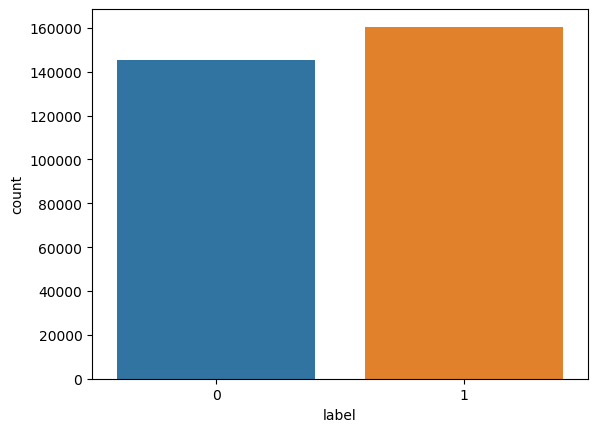

In [33]:
#checking distribution of target feature
sns.countplot(data=train_y, x='label')
plt.show()

In [34]:
%%time
#importing transformed testing set
s3 = boto3.client('s3')
key = f'{transformed_test_data_path}/data.csv'
obj = s3.get_object(Bucket=bucket, Key=key)
test_set = pd.read_csv(io.BytesIO(obj['Body'].read()))
test_set.shape

CPU times: user 342 ms, sys: 81.8 ms, total: 423 ms
Wall time: 823 ms


(131016, 59)

In [35]:
test_set.head(3)

,enrolled_plan_cost,person_age,number_of_people_covered,enrolled_er_annual_hsa_contribution,client_industry_rollup_agriculture_and_mining,client_industry_rollup_banking_and_finance,client_industry_rollup_business_services,client_industry_rollup_computer_service_and_software,client_industry_rollup_consumer_misc_product_and_manufacturing,client_industry_rollup_diversified_manufacturing,client_industry_rollup_education,client_industry_rollup_food_and_beverage,client_industry_rollup_government,client_industry_rollup_healthcare_and_medical,client_industry_rollup_insurance,client_industry_rollup_retail,client_industry_rollup_telecom,client_industry_rollup_transport_and_storage,client_industry_rollup_travel_recreation_and_leisure,client_industry_rollup_utilities_and_energy,person_gender_description_Male,person_gender_description_Unknown,marital_status_rollup_Married,marital_status_rollup_Single,marital_status_rollup_Unknown,client_is_ysa_Unknown,client_is_ysa_Y,client_has_corporate_exchange_Unknown,client_has_corporate_exchange_Y,client_hm_large_market_or_enterprise_Enterprise,client_hm_large_market_or_enterprise_LM,employment_status_rollup_Inactive,employment_status_rollup_Non-Employee,employment_status_rollup_Unknown,coverage_category_rollup_Covering_Others,coverage_category_rollup_Covering_Self,coverage_category_rollup_Unknown,source_system_TBA_3X,source_system_TBA_4X,enrollment_suggestion_source_UPoint Reimagine,enrollment_suggestion_source_Unknown,er_hsa_contribution_flag_new_1,enrolled_option_bc_dg_CDP-MDCL-SA-POS,enrolled_option_bc_dg_CDP-MDCL-SA-PPO,enrolled_option_bc_dg_EPO,enrolled_option_bc_dg_HDHP,enrolled_option_bc_dg_HDHP w/HSA,enrolled_option_bc_dg_HMO,enrolled_option_bc_dg_IND,enrolled_option_bc_dg_POS,enrolled_option_bc_dg_PPO,enrolled_option_bc_dg_Unknown,"person_expected_annual_base_salary_range_20,000 - 39,999","person_expected_annual_base_salary_range_40,000 - 59,999","person_expected_annual_base_salary_range_60,000 - 79,999","person_expected_annual_base_salary_range_80,000 - 99,999","person_expected_annual_base_salary_range_<20,000",person_expected_annual_base_salary_range_Unknown,label
0,0.0,32.0,1.0,62.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,7330.0,49.0,5.0,1500.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,2775.0,60.0,3.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [36]:
test_X = test_set.drop(columns='label')

test_X.shape

(131016, 58)

In [37]:
test_y = test_set[['label']]

test_y.shape

(131016, 1)

In [38]:
test_y.value_counts(normalize=True)

label
1        0.525111
0        0.474889
dtype: float64

In [ ]:
#checking distribution of target feature
sns.countplot(data=test_y, x='label')
plt.show()

## Training ML Models (with default parameters)

### LogisticRegression

In [ ]:
%%time
lr = LogisticRegression()

lr = lr.fit(train_X, train_y)

In [ ]:
pred_lr  = lr.predict(test_X)

### RandomForestClassifier

In [ ]:
%%time
rf = RandomForestClassifier()

rf = rf.fit(train_X, train_y)

In [ ]:
pred_rf  = rf.predict(test_X)

### SVC

In [ ]:
# svc = SVC()

# svc = svc.fit(train_X, train_y)

In [ ]:
# pred_svc  = svc.predict(test_X)

### DecisionTreeClassifier

In [ ]:
%%time
dt = DecisionTreeClassifier()

dt = dt.fit(train_X, train_y)

In [ ]:
pred_dt  = dt.predict(test_X)

### GaussianNB

In [ ]:
%%time
gnb = GaussianNB()

gnb = gnb.fit(train_X, train_y)

In [ ]:
pred_gnb  = gnb.predict(test_X)

### XGBClassifier

In [39]:
%%time
xgb = XGBClassifier()

xgb = xgb.fit(train_X.values, train_y.values)

CPU times: user 2min 22s, sys: 1.6 s, total: 2min 24s
Wall time: 9.18 s


In [40]:
pred_xgb  = xgb.predict(test_X)

### LGBMClassifier

In [ ]:
%%time
lgbm = LGBMClassifier()

lgbm = lgbm.fit(train_X.values, train_y.values)

In [ ]:
pred_lgbm  = lgbm.predict(test_X)

### KNeighborsClassifier

In [ ]:
%%time
knn = KNeighborsClassifier()
knn = knn.fit(train_X, train_y)

In [ ]:
pred_knn = knn.predict(test_X)

### MLPClassifier

In [ ]:
%%time
mlpc = MLPClassifier()
mlpc.fit(train_X, train_y)

In [ ]:
pred_mlpc = mlpc.predict(test_X)

## Classification Reports of above models on Test Set

In [ ]:
print("Logistic Regression:\n", classification_report(test_y, pred_lr))
print("ROC AUC score for data: ", roc_auc_score(test_y, lr.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
print("RandonForestClassifier:\n", classification_report(test_y, pred_rf))
print("ROC AUC score for data: ", roc_auc_score(test_y, rf.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
print("DecisionTreeClassifier:\n", classification_report(test_y, pred_dt))
print("ROC AUC score for data: ", roc_auc_score(test_y, dt.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
print("GaussianNB:\n", classification_report(test_y, pred_gnb))
print("ROC AUC score for data: ", roc_auc_score(test_y, gnb.predict_proba(test_X)[:,1], average='weighted'))

In [41]:
print("XGBClassifier:\n", classification_report(test_y, pred_xgb))
print("ROC AUC score for data: ", roc_auc_score(test_y, xgb.predict_proba(test_X)[:,1], average='weighted'))

XGBClassifier:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71     62218
           1       0.74      0.74      0.74     68798

    accuracy                           0.73    131016
   macro avg       0.73      0.73      0.73    131016
weighted avg       0.73      0.73      0.73    131016

ROC AUC score for data:  0.8098775861401315


In [ ]:
print("LGBMClassifier:\n", classification_report(test_y, pred_lgbm))
print("ROC AUC score for data: ", roc_auc_score(test_y, lgbm.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
print("KNeighborsClassifier:\n", classification_report(test_y, pred_knn))
print("ROC AUC score for data: ", roc_auc_score(test_y, knn.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
print("MLPClassifier:\n", classification_report(test_y, pred_mlpc))
print("ROC AUC score for data: ", roc_auc_score(test_y, mlpc.predict_proba(test_X)[:,1], average='weighted'))

## Features Importance from XGBoost Model with default parameters

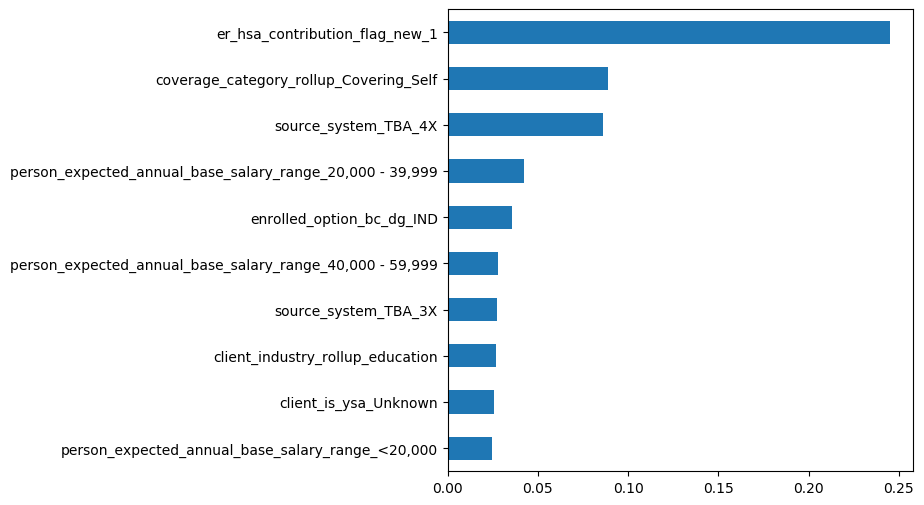

In [42]:
pd.Series(xgb.feature_importances_, index=train_X.columns).sort_values(ascending=True)[-10:].plot(kind='barh', figsize=(6,6))

In [48]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, auc,accuracy_score, cohen_kappa_score, plot_confusion_matrix, precision_recall_curve
#balanced_accuracy_scor
from sklearn.metrics import roc_curve

In [45]:
def expect_f1(y_prob, thres):
    idxs = np.where(y_prob >= thres)[0]
    tp = y_prob[idxs].sum()
    fp = len(idxs) - tp
    idxs = np.where(y_prob < thres)[0]
    fn = y_prob[idxs].sum()
    return 2*tp / (2*tp + fp + fn)

def optimal_threshold(y_prob):
    y_prob = np.sort(y_prob)[::-1]
    f1s = [expect_f1(y_prob, p) for p in y_prob]
    thres = y_prob[np.argmax(f1s)]
    return thres, f1s

In [46]:
# imporiving threshold for f1
thresholds = np.arange(0, 1, 0.001)
yhat = xgb.predict_proba(test_X)
scores = [f1_score(test_y, (yhat[:, 1] >= t).astype('int'), average='macro') for t in thresholds]
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


Threshold=0.527, F-Score=0.72624


In [53]:
thres, f1s = optimal_threshold(yhat)
print(f"Predicted Optimal Threshold is {thres} with F1 score {expect_f1(test_y, thres)}")

KeyboardInterrupt: 

In [47]:
metrics_keeper = pd.DataFrame()
classes = 2
class_names = ["No","Yes"]

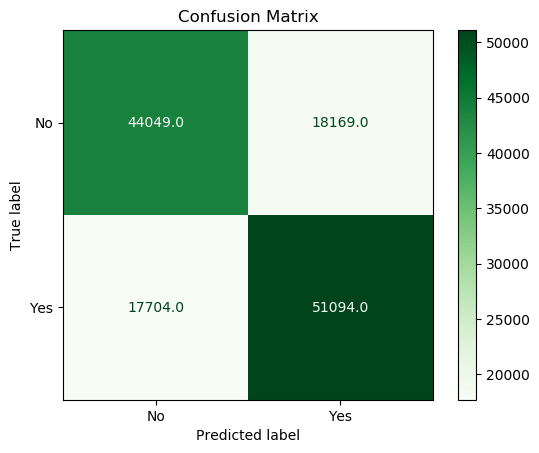

In [49]:
model_name = "xgb"
xgb = XGBClassifier()
xgb = xgb.fit(train_X.values, train_y.values)
pred  = xgb.predict(test_X)
accuracy = accuracy_score(test_y, pred)
kappa = cohen_kappa_score(test_y, pred)
roc = roc_auc_score(test_y, pred)
precision, recall, _ = precision_recall_curve(test_y, pred)
aucpr = auc(recall, precision)
clr = [i for i in classification_report(test_y, pred).split(" ") if i !="" and "\n" not in i][:-9]
plot_confusion_matrix(xgb, test_X, test_y, display_labels=class_names, cmap=plt.cm.Greens, values_format = '.1f')  
plt.title("Confusion Matrix")
plt.show()

In [59]:
#Get the confusion matrix
cf_matrix = confusion_matrix(test_y, pred)
print(cf_matrix)

[[44049 18169]
 [17704 51094]]


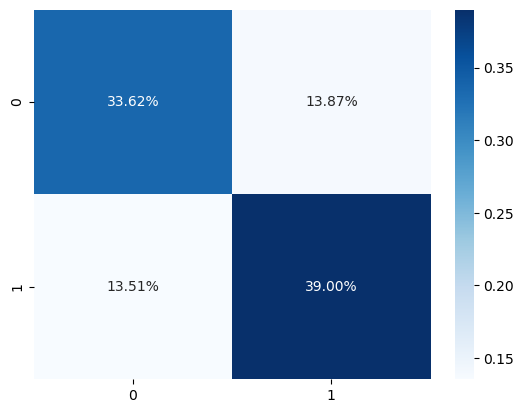

In [60]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [50]:
# FPR = FP/FP+TN 
FPR = 18169/(18169+51094)
round(FPR,2)

0.26

In [51]:
# TPR = TP/TP+FN
TPR = 44049/(44049+17704)
round(TPR,2)

0.71

In [52]:
tmp = np.sort(yhat)
f1s = np.array(f1s)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.plot(tmp, f1s[::-1])
ax.vlines(thres, 0, 1, linestyles="--")
ax.set_xlabel('Threshold')
ax.set_ylabel("F1 score")
ax.set_ylim([0, 1]);

ax = fig.add_subplot(1, 2, 2)
ax.plot(tmp[::-1], label="Predicted probability")
ax.plot(f1s, label='F1')
ax.plot(f1s/2, label='F1/2')
ax.set_xlabel('Index')
ax.legend()
ax.set_ylim([0, 1]);

NameError: name 'f1s' is not defined

In [54]:
print('Metrics Score on best Random Forest model on Testing Set')
print('Macro Recall=%.2f' %(recall_score(test_y, pred, average='macro')))
print('Macro Precision=%.2f' %(precision_score(test_y, pred, average='macro')))
print('Macro F1 Score=%.2f' %(f1_score(test_y, pred, average='macro')))
print('Macro ROC AUC=%.2f' %(roc_auc_score(test_y, yhat[:,1], average='macro')))
print('Macro AUPRC=%.2f' %(average_precision_score(test_y, yhat[:,1], average='macro')))
print('Macro Simple Accuracy=%.2f' %(accuracy_score(test_y, pred)))

Metrics Score on best Random Forest model on Testing Set
Macro Recall=0.73
Macro Precision=0.73
Macro F1 Score=0.73
Macro ROC AUC=0.81
Macro AUPRC=0.83
Macro Simple Accuracy=0.73


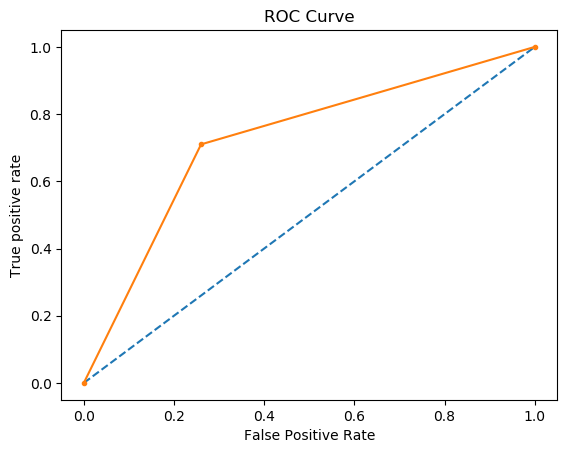

In [57]:
# from sklearn.metrics import roc_auc_score, roc_curve, calculated manually to adjust the plot
# print(roc_curve(y_val,pred))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.plot([0,0.26,1], [0,0.71,1], marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True positive rate")
plt.show()

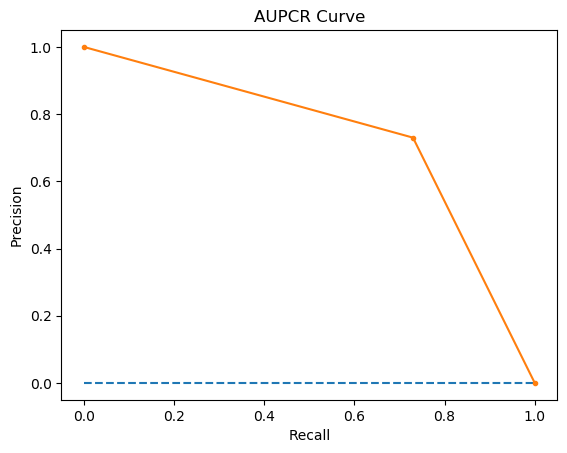

In [58]:
# plotting macro recall and precision
plt.plot([0, 1], [0, 0], linestyle='--', label='No Skill')
plt.plot([1,.73,0], [0,.73,1], marker='.')
plt.title("AUPCR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Hyper-parameter Tunning using Baysian Search for XGBoost Model

In [ ]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    
#     def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree,min_child_weight):
    def xgbc_cv(max_depth,learning_rate,n_estimators):
        # Storing function paramters in a dictionary which further will be passed to estimator function 
        hyperparameters = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators)#,
#             'reg_alpha': reg_alpha,
#             'reg_lambda': reg_lambda,
#             'gamma': gamma,
#             'subsample': subsample,
#             'colsample_bytree': colsample_bytree,
#             'min_child_weight': min_child_weight
        }

        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            **hyperparameters
        )


        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=train_X.values, y=train_y, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")

        return scores.mean()

    
    hyperparameter_space = {
    'max_depth': (5, 15),
    'learning_rate': (0.01, 0.5),
    'n_estimators' : (50,150)#,
#     'reg_alpha': (0.000001,2),
#     'reg_lambda': (0.000001,2),
#     'gamma': (0.0001,64),
#     'subsample': (0.5, 1),
#     'colsample_bytree': (0.3, 1),
#     'min_child_weight': (0,1)
    }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO

In [ ]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ei = bayesian_optimization(X_train, y_train,cv=10)

In [ ]:
%%time
gp_params = {"alpha": 1e-10}
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points (init_points) to establish a 'prior', then will perform 
# 10 interations (n_iter) to maximize the value of estimator function
# xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ucb', kappa=3, **gp_params)
xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ei', xi=1e-4, **gp_params)

In [ ]:
xgbcBO_ei.max

In [ ]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ei.max)
xgbcBO_ei_best_param1 = xgbcBO_ei.max['params']

In [ ]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_ei = XGBClassifier(
    max_depth=int(xgbcBO_ei_best_param1['max_depth']),
    learning_rate= round(xgbcBO_ei_best_param1['learning_rate'],2),
    n_estimators= int(xgbcBO_ei_best_param1['n_estimators']),
#     reg_alpha = round(xgbcBO_ei_best_param['reg_alpha'],2),
#     reg_lambda = round(xgbcBO_ei_best_param['reg_lambda'],2),
#     gamma = round(xgbcBO_ei_best_param['gamma'],2),
#     subsample = round(xgbcBO_ei_best_param['subsample'],2),
#     colsample_bytree = round(xgbcBO_ei_best_param['colsample_bytree'],2),
#     nthread = -1,
    objective='binary:logistic',
    seed = seed)

# Fitting the model
xgbc_ei.fit(X_train.values, y_train)

In [ ]:
pred = xgbc_ei.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train, pred))

In [ ]:
pred = xgbc_ei.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

In [ ]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    
#     def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree,min_child_weight):
    def xgbc_cv(subsample,colsample_bytree,min_child_weight):
        # Storing function paramters in a dictionary which further will be passed to estimator function 
        hyperparameters = {
#             'max_depth': int(max_depth),
#             'learning_rate': learning_rate,
#             'n_estimators': int(n_estimators)#,
#             'reg_alpha': reg_alpha,
#             'reg_lambda': reg_lambda,
#             'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight
        }

        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            max_depth=int(xgbcBO_ei_best_param1['max_depth']),
            learning_rate= round(xgbcBO_ei_best_param1['learning_rate'],2),
            n_estimators= int(xgbcBO_ei_best_param1['n_estimators']),
            **hyperparameters
        )


        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=train_X.values, y=train_y, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")

        return scores.mean()

    
    hyperparameter_space = {
#     'max_depth': (5, 15),
#     'learning_rate': (0.01, 0.5),
#     'n_estimators' : (50,150)#,
#     'reg_alpha': (0.000001,2),
#     'reg_lambda': (0.000001,2),
#     'gamma': (0.0001,64),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.3, 1),
    'min_child_weight': (0,10)
    }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO

In [ ]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ei = bayesian_optimization(X_train, y_train,cv=10)

In [ ]:
%%time
gp_params = {"alpha": 1e-10}
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points (init_points) to establish a 'prior', then will perform 
# 10 interations (n_iter) to maximize the value of estimator function
# xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ucb', kappa=3, **gp_params)
xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ei', xi=1e-4, **gp_params)

In [ ]:
xgbcBO_ei.max

In [ ]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ei.max)
xgbcBO_ei_best_param2 = xgbcBO_ei.max['params']

In [ ]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_ei = XGBClassifier(
    max_depth=int(xgbcBO_ei_best_param1['max_depth']),
    learning_rate= round(xgbcBO_ei_best_param1['learning_rate'],2),
    n_estimators= int(xgbcBO_ei_best_param1['n_estimators']),
#     reg_alpha = round(xgbcBO_ei_best_param['reg_alpha'],2),
#     reg_lambda = round(xgbcBO_ei_best_param['reg_lambda'],2),
#     gamma = round(xgbcBO_ei_best_param['gamma'],2),
    subsample = round(xgbcBO_ei_best_param2['subsample'],2),
    colsample_bytree = round(xgbcBO_ei_best_param2['colsample_bytree'],2),
    min_child_weight = round(xgbcBO_ei_best_param2['min_child_weight'],2),
    nthread = -1,
    objective='binary:logistic',
    seed = seed)

# Fitting the model
xgbc_ei.fit(X_train.values, y_train)

In [ ]:
pred = xgbc_ei.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train, pred))

In [ ]:
pred = xgbc_ei.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

In [ ]:
seed = 112 # Random seed

def bayesian_optimization(train_X, train_y, eval_metrics=f1_score, cv=10):
    
#     def xgbc_cv(max_depth,learning_rate,n_estimators,reg_alpha,reg_lambda,gamma,subsample,colsample_bytree,min_child_weight):
    def xgbc_cv(reg_alpha,reg_lambda,gamma):
        # Storing function paramters in a dictionary which further will be passed to estimator function 
        hyperparameters = {
#             'max_depth': int(max_depth),
#             'learning_rate': learning_rate,
#             'n_estimators': int(n_estimators)#,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'gamma': gamma#,
#             'subsample': subsample,
#             'colsample_bytree': colsample_bytree,
#             'min_child_weight': min_child_weight
        }

        # Creating object of XGBClassifier class with paramters got as function parameters
        estimator_function = XGBClassifier(
            objective='binary:logistic',
            nthread = -1,
            seed = seed,
            max_depth=int(xgbcBO_ei_best_param1['max_depth']),
            learning_rate= round(xgbcBO_ei_best_param1['learning_rate'],2),
            n_estimators= int(xgbcBO_ei_best_param1['n_estimators']),
            subsample = round(xgbcBO_ei_best_param2['subsample'],2),
            colsample_bytree = round(xgbcBO_ei_best_param2['colsample_bytree'],2),
            min_child_weight = round(xgbcBO_ei_best_param2['min_child_weight'],2),
            **hyperparameters
        )


        # We are performing K-fold cross validation to tune hyper-parameters, target metrics = F1 score
        # We can change 'K' using `cv` parameter
        scores = cross_val_score(estimator=estimator_function, X=train_X.values, y=train_y, scoring=make_scorer(eval_metrics), cv=cv, error_score="raise")

        return scores.mean()

    
    hyperparameter_space = {
#     'max_depth': (5, 15),
#     'learning_rate': (0.01, 0.5),
#     'n_estimators' : (50,150)#,
    'reg_alpha': (0,25),
    'reg_lambda': (0,25),
    'gamma': (1,40),
#     'subsample': (0.5, 1),
#     'colsample_bytree': (0.3, 1),
#     'min_child_weight': (0,10)
    }

    modelBO = BayesianOptimization(f=xgbc_cv, pbounds=hyperparameter_space, random_state=seed, verbose=10)
    
    return modelBO

In [ ]:
# By default evluation metrics is f1 score and cross-validations are 10
xgbcBO_ei = bayesian_optimization(X_train, y_train,cv=10)

In [ ]:
%%time
gp_params = {"alpha": 1e-10}
# Finally we call .maximize method of the optimizer with the appropriate arguments
# kappa is a measure of 'aggressiveness' of the bayesian optimization process
# The algorithm will randomly choose 3 points (init_points) to establish a 'prior', then will perform 
# 10 interations (n_iter) to maximize the value of estimator function
# xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ucb', kappa=3, **gp_params)
xgbcBO_ei.maximize(init_points=3, n_iter=20, acq='ei', xi=1e-4, **gp_params)

In [ ]:
xgbcBO_ei.max

In [ ]:
# Fetching paramters corrosponding to best score (target)
# xgbcBO_best_param = xgbcBO.res[np.argmax([x['target'] for x in xgbcBO.res])]['params']
print(xgbcBO_ei.max)
xgbcBO_ei_best_param3 = xgbcBO_ei.max['params']

In [ ]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_ei = XGBClassifier(
    max_depth=int(xgbcBO_ei_best_param1['max_depth']),
    learning_rate= round(xgbcBO_ei_best_param1['learning_rate'],2),
    n_estimators= int(xgbcBO_ei_best_param1['n_estimators']),
    reg_alpha = round(xgbcBO_ei_best_param3['reg_alpha'],2),
    reg_lambda = round(xgbcBO_ei_best_param3['reg_lambda'],2),
    gamma = round(xgbcBO_ei_best_param3['gamma'],2),
    subsample = round(xgbcBO_ei_best_param2['subsample'],2),
    colsample_bytree = round(xgbcBO_ei_best_param2['colsample_bytree'],2),
    min_child_weight = round(xgbcBO_ei_best_param2['min_child_weight'],2),
    nthread = -1,
    objective='binary:logistic',
    seed = seed)

# Fitting the model
xgbc_ei.fit(X_train.values, y_train)

In [ ]:
pred = xgbc_ei.predict(X_train)
print("XGBClassifier (TRAINING SET):\n", classification_report(y_train, pred))
print("ROC AUC score for data: ", roc_auc_score(y_train, pred))

In [ ]:
pred = xgbc_ei.predict(X_test)
print("XGBClassifier (TESTING SET):\n", classification_report(y_test, pred))
print("ROC AUC score for data: ", roc_auc_score(y_test, pred))

### Fitting XGBoost Model with Best Paramaters

In [ ]:
%%time
seed = 112 # Random seed

#creating object of XGBClassifier class with best hyper-parameters obtained from BayesianOptimization
xgbc_best = XGBClassifier(
    max_depth = 11,
    learning_rate = 0.19,
    n_estimators = 145,
    reg_alpha = 12.09,
    reg_lambda = 8.17,
    gamma = 1.08,
    subsample = 0.99,
    colsample_bytree = 0.97,
    min_child_weight = 5.83,
    nthread = -1,
    objective='binary:logistic',
    seed = seed)

# Fitting the model
xgbc_best.fit(train_X.values, train_y)

In [ ]:
pred_train = xgbc_best.predict(train_X)
print("XGBClassifier (TRAINING SET):\n", classification_report(train_y, pred_train))
print("ROC AUC score for data: ", roc_auc_score(train_y, xgbc_best.predict_proba(train_X)[:,1], average='weighted'))

In [ ]:
pred_test = xgbc_best.predict(test_X)
print("XGBClassifier (TESTING SET):\n", classification_report(test_y, pred_test))
print("ROC AUC score for data: ", roc_auc_score(test_y, xgbc_best.predict_proba(test_X)[:,1], average='weighted'))

#### Results on Train Set

In [ ]:
print('Metrics Score on best XGBoost model on Training Set')
print('Recall:'.ljust(20, " "),recall_score(train_y, pred_train, average='weighted'))
print('Precision: '.ljust(20, " "),precision_score(train_y, pred_train, average='weighted'))
print('F1: '.ljust(20, " "),f1_score(train_y, pred_train, average='weighted'))
print('Simple Accuracy: '.ljust(20, " "),accuracy_score(train_y, pred_train))
print('ROC AUC: '.ljust(20, " "),roc_auc_score(train_y, xgbc_best.predict_proba(train_X)[:,1], average='weighted'))
print('AUPRC: '.ljust(20, " "),average_precision_score(train_y, xgbc_best.predict_proba(train_X)[:,1], average='weighted'))

In [ ]:
plot_precision_recall_curve(estimator=xgbc_best, X=train_X, y=train_y, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
# plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

In [ ]:
plot_roc_curve(estimator=xgbc_best, X=train_X, y=train_y, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
# plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

In [ ]:
plot_confusion_matrix(estimator=xgbc_best, X=train_X, y_true=train_y, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
# plt.savefig('Confusion Matrix.png')
plt.show()

#### Results on Test Set

In [ ]:
print('Metrics Score on best XGBoost model on Testing Set')
print('Recall:'.ljust(20, " "),recall_score(test_y, pred_test, average='weighted'))
print('Precision: '.ljust(20, " "),precision_score(test_y, pred_test, average='weighted'))
print('F1: '.ljust(20, " "),f1_score(test_y, pred_test, average='weighted'))
print('Simple Accuracy: '.ljust(20, " "),accuracy_score(test_y, pred_test))
print('ROC AUC: '.ljust(20, " "),roc_auc_score(test_y, xgbc_best.predict_proba(test_X)[:,1], average='weighted'))
print('AUPRC: '.ljust(20, " "),average_precision_score(test_y, xgbc_best.predict_proba(test_X)[:,1], average='weighted'))

In [ ]:
plot_precision_recall_curve(estimator=xgbc_best, X=test_X, y=test_y, response_method='predict_proba', name='XGBoost')
plt.title('Precision Recall Curve', size=15)
# plt.savefig('Precision Recall Curve - XGBoost.png')
plt.show()

In [ ]:
plot_roc_curve(estimator=xgbc_best, X=test_X, y=test_y, response_method='predict_proba', name='XGBoost')
plt.title('Receiver Operating Characteristic (ROC) Curve', size=15)
# plt.savefig('Receiver Operating Characteristic (ROC) Curve.png')
plt.show()

In [ ]:
plot_confusion_matrix(estimator=xgbc_best, X=test_X, y_true=test_y, cmap='Blues',values_format='.0f')
plt.title('Confusion Matrix', size=15)
# plt.savefig('Confusion Matrix.png')
plt.show()

In [ ]:
pd.Series(xgbc_best.feature_importances_, index=train_X.columns).sort_values(ascending=True)[-15:].plot(kind='barh', figsize=(6,6))
# plt.savefig('Feature Importance XGBoost.png')
plt.show()

## Saving Final (Best) ML Model

In [ ]:
# WRITE
s3_client = boto3.client('s3')

with tempfile.TemporaryFile() as fp:
    joblib.dump(xgbc_best, fp)
    fp.seek(0)
    s3_client.put_object(Body=fp.read(), Bucket=bucket, Key=model_name_and_path)
print(f'Model saved at this location ------> s3://{bucket}/{model_name_and_path}')

In [ ]:
# # READ
# s3_client = boto3.client('s3')

# with tempfile.TemporaryFile() as fp:
#     s3_client.download_fileobj(Fileobj=fp, Bucket=bucket, Key=model_name_and_path)
#     fp.seek(0)
#     model = joblib.load(fp)

## Using SHAP values to interpret the model

In [ ]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict, test_X[:2000])
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X[:2000])

In [ ]:
pred_prob = xgbc_best.predict(test_X[:2000])

In [ ]:
pred_prob.mean()

In [ ]:
shap_values.base_values

In [ ]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
shap.plots.force(shap_values.base_values[2],shap_values.values[2], feature_names=test_X.columns)

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
shap.decision_plot(shap_values.base_values[0], shap_values.values[0])

In [ ]:
sex = ["ER Contributing" if shap_values[i,"er_hsa_contribution_flag_new_1"].data == 1 else "ER not Contributing" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

In [ ]:
shap.plots.bar(shap_values.cohorts(3).abs.mean(0))

In [ ]:
shap_df = pd.DataFrame(shap_values.values, columns=train_X.columns)
shap_df.shape

In [ ]:
shap_df.head()

In [ ]:
data_df = pd.DataFrame(shap_values.data, columns=train_X.columns)
data_df.shape

In [ ]:
data_df.head(3)

In [ ]:
corr_coef = []
for col in train_X.columns:
    corr_coef.append(np.corrcoef(shap_df[col],data_df[col])[1][0])

In [ ]:
color_list = ['blue' if i>0 else 'red' for i in corr_coef]

In [ ]:
plot_df = pd.DataFrame(shap_df.abs().mean(axis=0), columns=['mean(|SHAP values|)'])
plot_df['corr_coef'] = corr_coef
plot_df['corr color'] = color_list
plot_df = plot_df.sort_values('mean(|SHAP values|)', ascending=True).reset_index()
plot_df = plot_df.iloc[-10:,:]
colorlist = plot_df['corr color']

In [ ]:
# f = plt.figure()
plot_df.plot.barh(x='index', y='mean(|SHAP values|)',color=colorlist, figsize=(5,6), legend=False)
plt.xlabel("mean(|SHAP Value|) (Blue = Positive Impact)")
plt.ylabel('')
plt.savefig('shap.png',bbox_inches='tight', dpi=600)
plt.show()

In [ ]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict, test_X[:200])
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X[:100])

In [ ]:
pred_prob = xgbc_best.predict(test_X[:100])

In [ ]:
pred_prob.mean()

In [ ]:
shap_values.base_values

In [ ]:
# shap.initjs()
# shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
# shap.plots.force(shap_values.base_values[2],shap_values.values[2], feature_names=test_X.columns)

In [ ]:
explainer.

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values,plot_type="bar")
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
# Fits the explainer
explainer1 = shap.TreeExplainer(xgbc_best, model_output="margin")
# Calculates the SHAP values - It takes some time
shap_values1 = explainer1.shap_values(test_X[:200].values)

In [ ]:
shap_values1.base

In [ ]:
np.mean(np.abs(shap_values1))

In [ ]:
explainer1.expected_value

In [ ]:
shap.decision_plot(base_value=explainer1.expected_value,shap_values=shap_values1[0],feature_names=test_X.columns.tolist())

In [ ]:
shap.summary_plot(shap_values1, test_X[:100], plot_type="bar")

In [ ]:
pred_prob.mean()

In [ ]:
shap_values.base_values

In [ ]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
shap.plots.force(shap_values.base_values[5],shap_values.values[0], feature_names=test_X.columns)

In [ ]:
f = plt.figure()
shap.summary_plot(shap_values)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
f = plt.figure()
shap.plots.bar(shap_values, max_display=15)
# f.savefig('shap.png',bbox_inches='tight', dpi=600)

In [ ]:
%%time
# Fits the explainer
explainer = shap.Explainer(xgbc_best)
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X[:100])

In [ ]:
pred_prob = xgbc_best.predict(test_X[:100])

In [ ]:
pred_prob.mean()

In [ ]:
shap_values.base_values

In [ ]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
shap.plots.force(shap_values.base_values[5],shap_values.values[0], feature_names=test_X.columns)

In [ ]:
shap.summary_plot(shap_values)

In [ ]:
shap.plots.bar(shap_values, max_display=15)
plt.savefig('shap.png')

In [ ]:
shap.decision_plot(shap_values.base_values[0], shap_values.values[0])

In [ ]:
sex = ["ER Contributing" if shap_values[i,"er_hsa_contribution_flag_new_1"].data == 1 else "ER not Contributing" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

In [ ]:
shap.plots.bar(shap_values.cohorts(3).abs.mean(0))

In [ ]:
%%time
# Fits the explainer
explainer = shap.TreeExplainer(xgbc_best)
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X[:100])

In [ ]:
pred_prob = xgbc_best.predict(test_X[:100])

In [ ]:
pred_prob.mean()

In [ ]:
shap_values.base_values

In [ ]:
shap.initjs()
shap.plots.force(shap_values.base_values[5],shap_values.values[5], feature_names=test_X.columns)

In [ ]:
shap.plots.force(shap_values.base_values[5],shap_values.values[0], feature_names=test_X.columns)

In [ ]:
shap.summary_plot(shap_values)

In [ ]:
shap.plots.bar(shap_values, max_display=15)
plt.savefig('shap.png')

In [ ]:
shap.decision_plot(shap_values.base_values[0], shap_values.values[0])

In [ ]:
# Fits the explainer
explainer = shap.Explainer(xgbc_best.predict_proba, test_X[:100])
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_X[:100])

In [ ]:
pred_prob = xgbc_best.predict_proba(test_X[:100])

In [ ]:
pred_prob[:, 1].mean()

In [ ]:
shap_values.values[5,:,1]

In [ ]:
# shap.initjs()
shap.plots.force(shap_values.base_values[5,1],shap_values.values[5,:,1], feature_names=test_X.columns)

In [ ]:
shap.plots.force(shap_values.base_values[0,1],shap_values.values[0,:,1], feature_names=test_X.columns)

In [ ]:
shap.summary_plot(shap_values.values[:,:,1])

In [ ]:
shap_values.values[:,:,1][0]

In [ ]:
shap.plots.bar(shap_values.values[:,:,1], max_display=15)